In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# --------------------------------------------------
# 1. Load MNIST Dataset
# --------------------------------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
# 2. Create tf.data pipeline
# --------------------------------------------------
# Convert to tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [4]:
# Preprocessing function
def preprocess(image, label):
    image = tf.expand_dims(image, -1)                # add channel dim: (28,28) -> (28,28,1)
    image = tf.image.grayscale_to_rgb(image)         # convert to 3 channels (RGB); pre-trained model we’re using (MobileNetV2)
    image = tf.image.resize(image, [128, 128])       # resize to MobileNetV2 input size (actually uses 224 x 224); saving memory required
    image = image / 255.0                            # normalize to [0,1]
    return image, label

In [5]:
# Apply preprocessing, batching, prefetching
batch_size = 32
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [6]:
# --------------------------------------------------
# 3. Load Pre-trained Base Model (MobileNetV2)
# --------------------------------------------------
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",  # use pretrained weights; Loads model weights that were trained on the ImageNet dataset.features like edges, corners, textures, shapes
    include_top=False,   # Removes classification head (1000 classes), leaving only the convolutional base (feature extractor). we want to classify MNIST digits (10 classes)
    input_shape=(128, 128, 3)   # using smaller size for Colab efficiency; # expected input size, MobileNetV2 was trained on 224×224 RGB images.So we resize MNIST digits from (28×28×1) → (224×224×3).
)
base_model.trainable = False  # freeze pretrained layers

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
# --------------------------------------------------
# 4. Build Model with New Head
# --------------------------------------------------
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), #spatial average of each feature map. Converts variable-sized feature maps into a fixed-length vector.
    # If feature maps = (4,4,1280), after pooling → (1280,).
    # MobileNetV2 doesn’t give you raw pixels, Instead, it outputs feature maps. Height, width, channels
    # There are 1280 feature maps(Channels), Each feature map is a 4×4 grid (spatial representation of features).
    # Each channel detects some pattern (edges, textures, shapes).
    layers.Dense(128, activation='relu'), #A fully connected (hidden) layer with 128 neurons. ReLU adds non-linearity → helps model learn complex patterns
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')  # 10 classes for MNIST
])

In [8]:
# --------------------------------------------------
# 5. Compile
# --------------------------------------------------
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
# --------------------------------------------------
# 6. Train
# --------------------------------------------------
history = model.fit(train_ds, epochs=3, validation_data=test_ds)

# --------------------------------------------------
# 7. Evaluate
# --------------------------------------------------
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(f"\n✅ Transfer Learning Test Accuracy: {test_acc:.4f}")


Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 61s 24ms/step - accuracy: 0.8927 - loss: 0.3340 - val_accuracy: 0.9643 - val_loss: 0.1089
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 51s 14ms/step - accuracy: 0.9618 - loss: 0.1194 - val_accuracy: 0.9693 - val_loss: 0.1015
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9673 - loss: 0.0969 - val_accuracy: 0.9734 - val_loss: 0.0870
313/313 - 3s - 11ms/step - accuracy: 0.9734 - loss: 0.0870

✅ Transfer Learning Test Accuracy: 0.9734


In [ ]:
# # --------------------------------------------------
# # 8. Plot Training Curves
# # --------------------------------------------------
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [10]:
# --------------------------------------------------
# 8. Predict on Test Data
# --------------------------------------------------
# Preprocess test images manually for visualization
x_test_rgb = np.expand_dims(x_test, -1)
x_test_rgb = np.repeat(x_test_rgb, 3, axis=-1)               # grayscale -> RGB
x_test_resized = tf.image.resize(x_test_rgb, [128, 128]) / 255.0
x_test_resized = x_test_resized.numpy()


# Predict
predictions = model.predict(x_test_resized, batch_size=32)
predicted_labels = np.argmax(predictions, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step


In [11]:
# 9. Visualization Function
# --------------------------------------------------
def plot_sample(i, predictions_array, true_label, img):
    pred_label = np.argmax(predictions_array)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)  # show original 28x28 image

    # Label color → green if correct, red if wrong
    color = "green" if pred_label == true_label else "red"
    plt.xlabel(f"Pred: {pred_label}, True: {true_label}", color=color)

i → index of the sample (not used directly inside, but useful for looping).

predictions_array → model’s predicted probabilities for all 10 classes (output of model.predict).

true_label → the actual digit label (0–9).

img → the image data (28×28 grayscale digit).


---

pred_label = np.argmax(predictions_array)
predictions_array looks like:
[0.01, 0.02, 0.8, 0.05, ... , 0.01] → 10 values, one per class.

np.argmax(...) finds the index of the maximum probability → the predicted digit.

Example: if class 2 has the highest probability, pred_label = 2.


---
plt.grid(False)
plt.xticks([])
plt.yticks([])



---

plt.imshow(img, cmap=plt.cm.binary)  # show original 28x28 image
Displays the digit image.

cmap=plt.cm.binary → shows it in black & white (instead of color heatmap).


---
color = "green" if pred_label == true_label else "red"
If prediction is correct → text color = green.

If wrong → text color = red.

This is how we visually mark correct vs. incorrect predictions.


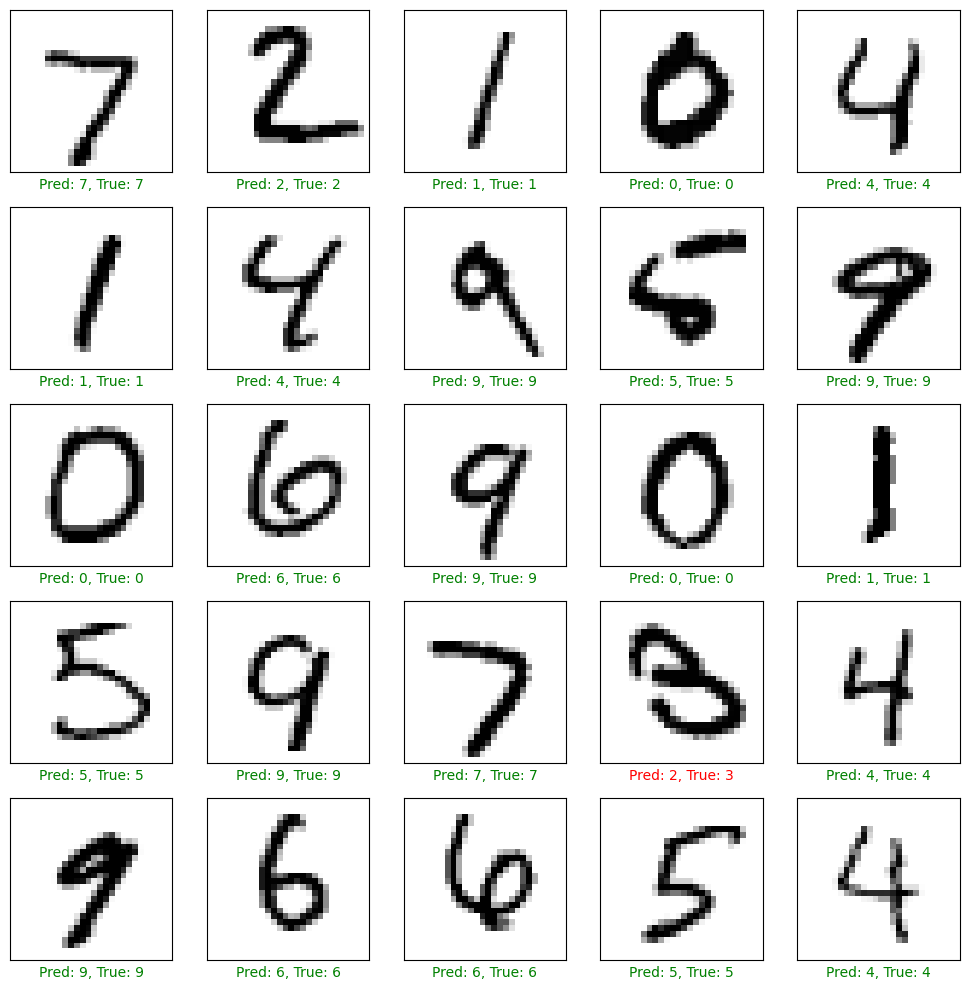

In [12]:
# --------------------------------------------------
# 10. Show First 25 Predictions
# --------------------------------------------------
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plot_sample(i, predictions[i], y_test[i], x_test[i])  # plot original 28x28
plt.tight_layout()
plt.show()